### Copyright (C) Infineon Technologies AG 2025
 
Copyright (c) 2025, Infineon Technologies AG, or an affiliate of Infineon Technologies AG. All rights reserved.
This software, associated documentation and materials ("Software") is owned by Infineon Technologies AG or one of its affiliates ("Infineon") and is protected by and subject to worldwide patent protection, worldwide copyright laws, and international treaty provisions. Therefore, you may use this Software only as provided in the license agreement accompanying the software package from which you obtained this Software. If no license agreement applies, then any use, reproduction, modification, translation, or compilation of this Software is prohibited without the express written permission of Infineon.

Disclaimer: UNLESS OTHERWISE EXPRESSLY AGREED WITH INFINEON, THIS SOFTWARE IS PROVIDED AS-IS, WITH NO WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ALL WARRANTIES OF NON-INFRINGEMENT OF THIRD-PARTY RIGHTS AND IMPLIED WARRANTIES SUCH AS WARRANTIES OF FITNESS FOR A SPECIFIC USE/PURPOSE OR MERCHANTABILITY. Infineon reserves the right to make changes to the Software without notice. You are responsible for properly designing, programming, and testing the functionality and safety of your intended application of the Software, as well as complying with any legal requirements related to its use. Infineon does not guarantee that the Software will be free from intrusion, data theft or loss, or other breaches ("Security Breaches"), and Infineon shall have no liability arising out of any Security Breaches. Unless otherwise explicitly approved by Infineon, the Software may not be used in any application where a failure of the Product or any consequences of the use thereof can reasonably be expected to result in personal injury.

## AI Enhanced PID Example

This example demonstrates proportional-integral-derivative (PID) controller refining the execution of the planned trajectory. Controller in that case is "enhanced" by simple MLP network, which is tuning the controller in real time, i.e., it modifies the PID gains. This approach enables achieving higher driving comfort and adaptability to unseen scenarios as opposed to the conventional controller with constant parameters. The PID Controller has been implemented in Simulink and converted into binary FMU model. Then, we are making use of FMPy library enabling model loading and execution. The results of model execution are plotted in separate graphs, i.e., we are plotting P, I, D coefficients and steering angles for both controller variants. Plots include also cross-track error (CTE), which is a setpoint for the controller.

### Dataset Overview

We use the dataset collected in the simulation environment, i.e., IPG CarMaker. The dataset consists of 138 samples representing dynamic vehicle parameters and shape of the driven trajectory mapped into corresponding PID gains.

### Notebook Structure

1. **Import function definitions**
2. **Data Loading and Preprocessing**
3. **Model Definition**
4. **Model Creation and Training**
5. **Do an Exemplary Prediction**
6. **Model Evaluation**
7. **Plot Learning Curves**
8. **Perform a Simulation in AI mode**
9. **Perform a Simulation in Non-AI mode**
10. **Plot Simulation Results**
11. **Export and Save Model and Data**
12. **Compiling the Model for AURIX&trade;**

#### Import necessary functions
- Add the parent directory to the Python path so we can import from CentralScripts
- Import helper functions for model definition, data loading, preprocessing, benchmarking etc.

In [1]:
import sys
import os

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.helper_functions import *
from modelling_helper import *

#### Data Loading and Preprocessing

- Data is loaded into numpy arrays
- Data is normalized for better model training, data normalization is being done in the load_data() function

In [2]:
# Load and preprocess training and evaluation data
data_x, data_y, eval_x, eval_y = load_data()

INFO:root:DATA LOADED SUCCESSFULLY
INFO:root:LABELS LOADED SUCCESSFULLY


#### Model Definition

This code snippet defining simple MLP network consisting of three layers is included in ```modelling_helper.py``` file in ```KerasModel``` class. You are invited to experiment with neural network parameters and define your own model.

#### Model Creation and Training
- TensorFlow model is created
- TensorFlow model is trained
- Model prediction is calculated for given sample

In [3]:
# Neural Network in TensorFlow framework
origin = "tf"

# Neural Network model is instantiated
model = get_model(origin)

# Choose your model_name
model_name = "pid_model"

# Add an exemplary input as numpy array
input_target = data_x[20]  # Example input for the model
input_target = input_target.astype(np.float32)

# Train your model
model, history = train_model(model, data_x, data_y)
model.summary()

# Get exemplary predictions
output_target = get_predictions(origin, model, input_target)

Epoch 1/200


/home/wsluser/git/ai-model-zoo-productive/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 55.9821 - val_loss: 50.0436
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 55.2867 - val_loss: 49.3681
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 54.5664 - val_loss: 48.6775
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 53.8416 - val_loss: 47.9680
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 53.0807 - val_loss: 47.2515
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 52.3292 - val_loss: 46.5279
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 51.5593 - val_loss: 45.7856
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 50.7741 - val_loss: 45.0217
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 49.9560 - val_loss: 44.2338
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 49.1263 - val_loss: 43.4206
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 48.2596 - val_loss: 42.5708
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 47.33

Model: "keras_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795 (10.92 KB)

 Trainable params: 931 (3.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,864 (7.29 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


#### Do an Exemplary Prediction

- It shows how to do the prediction on single data sample

In [4]:
input_sample = tf.convert_to_tensor(data_x[20].reshape(1, 10))

model.predict(input_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[7.309806 , 6.9948897, 6.351649 ]], dtype=float32)

#### Model Evaluation

- Perform an evaluation on test dataset (it calcualtes MSE)

In [5]:
eval_res = model.evaluate(eval_x, eval_y)
print("res   ", eval_res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.7134
res    5.713425636291504


#### Plot Learning Curves

- Plots validation and training curves

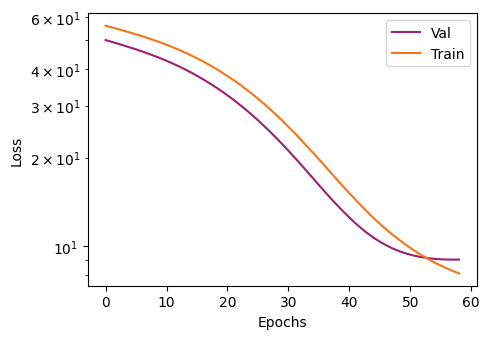

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.set_yscale("log")
ax.plot(
    history.epoch, history.history["val_loss"], label="Val", color=COLORS["BERRY_MAIN"]
)
ax.plot(history.epoch, history.history["loss"], label="Train", color=COLORS["SUN_MAIN"])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.tight_layout()

#### Perform a Simulation in AI mode

 - AI model is passed to the simulation function
 - AI algorithm tunes a conventional Proportional-Integral-Derivative (PID) controller in real time
 - Graph below depicts P, I and D coefficients, cross-track error (CTE) and steering angle
 - It can be noticed P, I and D coefficients are changing during execution what increases safety and driving comfort

In [7]:
res_ai = simulate_custom_input(
    input_paths=input_data_paths,
    model=model,
    show_plot=False,
    batch_prediction=batch_prediction,
    ai_mode=True,
)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


#### Perform a Simulation in non-AI mode

- In that case ```ai_mode``` argument of ```simulate_custom_input``` function is set to ```False```
- P, I and D coefficients are constant
- Steering angle is less stable (it includes jerks)

In [8]:
res_non_ai = simulate_custom_input(
    input_paths=input_data_paths,
    model=model,
    show_plot=False,
    batch_prediction=batch_prediction,
    ai_mode=False,
)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


#### Plot Simulation Results
- plot simulation results for both cases with ai enhancement and without
- it can be seen controller coefficient are changing during model execution what enables controller's adaptivity to unseen scenarios and increases driving comfort 

In [9]:
plot_stacked_results(res_ai, res_non_ai)

#### Export and Save Model and Data

We now export model, input, and output data: 
- the model will be converted into ONNX
- input, and output will be stored ad pb.

In [10]:
# export model and data as ONNX and pb
save_all(model_name, input_target, output_target, model, origin)
test_onnx_pb(model_name)

Directory already exists: out/pid_model/test_pid_model


INFO:tf2onnx.tfonnx:Using tensorflow=2.16.2, onnx=1.17.0, tf2onnx=1.16.1/15c810
INFO:tf2onnx.tfonnx:Using opset <onnx, 15>
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.optimizer:Optimizing ONNX model
INFO:tf2onnx.optimizer:After optimization: Identity -2 (2->0)


Output matches expected output within tolerance.


#### Compiling the Model for AURIX&trade; 

We now generate a C file from the ONNX and convert this into an elf file next. The elf file is executed using the open-source hardware emulator QEMU to estimate the execution. The returned elf file is not meant to be flashed onto a real AURIX&trade;. We are plotting number of clock cycles required to execute a given model on the target platform.

In [11]:
# Check if the docker container is running. If not, start it.
ensure_docker_container()

Docker container 'unruffled_galois' (from image 'aurix_ai_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


In [12]:
from CentralScripts.python_flask_client import CallTools

model_folder, onnx_model_file = get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

Target folder out/pid_model/test_pid_model/TC3 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
Target folder out/pid_model/test_pid_model/TC4 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


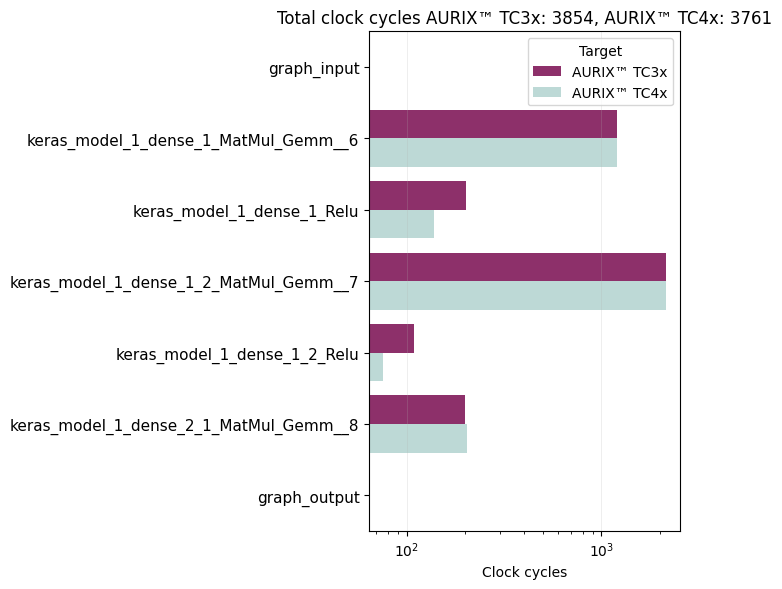

In [13]:
plot_execution_timing(model_name)